In [2]:
!python3 --version

Python 3.11.5


In [37]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import datetime
import time
import os

# Посчитать сложность алгоритма для альфы

## Create Dataset

In [8]:
dataset_dir = './USA_2010-2014_HLOCV'
os.listdir(dataset_dir)

['Open.csv', 'High.csv', 'Close.csv', 'Low.csv', 'Volume.csv']

In [9]:
open_df = pd.read_csv(dataset_dir + '/Open.csv')
high_df = pd.read_csv(dataset_dir + '/High.csv')
close_df = pd.read_csv(dataset_dir + '/Close.csv')
low_df = pd.read_csv(dataset_dir + '/Low.csv')
volume_df = pd.read_csv(dataset_dir + '/Volume.csv')

volume = volume_df.drop(volume_df.columns[0], axis=1).to_numpy().T
close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T
high = high_df.drop(high_df.columns[0], axis=1).to_numpy().T
low = low_df.drop(low_df.columns[0], axis=1).to_numpy().T

## Alpha 28

**scale(((correlation(adv20, low, 5) + ((high + low) / 2)) - close))**

In [11]:
def neutralize(alpha):
    if len(alpha.shape) == 1:
        if not np.array_equal(alpha, np.zeros_like(alpha)): # 2m
            return alpha - (alpha.sum() / len(alpha)) # 2m
        else:
            return alpha
    else: # if alpha is a matrix of states
        alpha_states_neutralized = np.array([neutralize(_alpha) for _alpha in alpha])
        return alpha_states_neutralized

In [12]:
def neutralize_with_dropout(alpha, true_false_vector):
    if len(alpha.shape) == 1:
        indexes = [j for j in range(len(true_false_vector)) if true_false_vector[j] == 1] # m

        _alpha =  alpha[indexes] # zeros_num
        _alpha = neutralize(_alpha) # 2m

        for _idx, idx in enumerate(indexes): # zeros_num
            alpha[idx] = _alpha[_idx]

        return alpha # 3*m + 2 * zeros_num

    else:

        new_alpha = np.zeros_like(alpha)  # n * m

        for idx, (_alpha, zeros_vec) in enumerate(zip(alpha, true_false_vector)): # n
            if not np.array_equal(_alpha, np.zeros_like(_alpha)): # 2*m
                new_alpha[idx] += neutralize_with_dropout(_alpha, zeros_vec) # 3*m + 2 * zeros_num

        return new_alpha # n (5* m + 2 * zeros_num)


In [59]:
def normalize(alpha):
    if len(alpha.shape) == 1:
        return alpha / np.abs(alpha).sum()
    
    else:
        alpha_states_normalized = np.zeros_like(alpha)

        for idx, _alpha in enumerate(alpha): # n

            if np.abs(_alpha).sum() != 0: # m
                alpha_states_normalized[idx] += _alpha / np.abs(_alpha).sum() # m
            else:
                alpha_states_normalized[idx] += _alpha

        return alpha_states_normalized # n * 2*m

In [60]:
def average_dayly_volume(volume, day_step):
    adv = np.zeros_like(volume)
    for i in range(day_step, len(volume)): # (n - w) * w
        adv[i] = volume[i-day_step:i].mean(axis=0)
    return adv

In [61]:
def ts_correlation(x, y):
    corr_vec = np.zeros(x.shape[1])
    for idx, (_x, _y) in enumerate(zip(x, y)):
        corr_vec[idx] = calc_alphas_corr(_x, _y) # 4m
    return corr_vec # c_w * 4m

In [62]:
def scale(matrix, a):
    for i in range(len(matrix)):
        if np.abs(matrix[i]).sum() != 0:
            matrix[i] = matrix[i] * 2 / np.abs(matrix[i]).sum()
    return matrix

In [63]:
def calc_alphas_corr(alpha1, alpha2):
    def std (vector): # m + m
        return np.sqrt(np.sum((vector - vector.mean())**2) / (len(vector) - 1))
    # 2m
    corr = np.sum((alpha1 - alpha1.mean()) * (alpha2 - alpha2.mean())) / (std(alpha1) * std(alpha2))

    return corr # 4m

In [64]:
def decay (alpha_matrix, n):
    factors = (np.arange(1, n + 2)) / (n+1) # d_w

    _new_alpha_states = alpha_matrix.copy()

    for idx in range(n+1, len(alpha_matrix)): # n - d_w
        _alpha = alpha_matrix[idx-n-1:idx] * np.array([factors]).T # d_w * m
        if not np.array_equal(_alpha, np.zeros_like(_alpha)): # 2 * d_w * m
            _new_alpha_states[idx] = _alpha.sum(axis=0) # m
    
    return _new_alpha_states # (n - d_w) * (3 * d_w * m + m)

In [65]:
def CutMiddle(alpha, n):

    if len(alpha.shape) == 1:

        indexes = np.argsort(alpha)
        false_true_vec = np.ones(len(indexes))

        borders = [len(alpha) // 2 - n // 2, len(alpha) // 2 + n // 2 + n%2]

        _indexes = indexes[np.arange(borders[0]-1, borders[1]-1)]

        for idx in _indexes:
            alpha[idx] = 0.
            false_true_vec[idx] = 0

        return alpha, false_true_vec
    
    else:
        new_matrix = np.zeros_like(alpha)
        zero_matrix = np.zeros_like(alpha)
        
        for idx, _alpha in enumerate(alpha):
            if not np.array_equal(_alpha, np.zeros_like(_alpha)):
                new_alpha, false_true_vec = CutMiddle(_alpha, n)
                new_matrix[idx] = new_alpha
                zero_matrix[idx] = false_true_vec
               
        return new_matrix, zero_matrix

In [66]:
def CutOutliers(alpha, n, make_tf_vec=True):    
    if len(alpha.shape) == 1:
        indexes = np.argsort(alpha) # m*m

        false_true_vec = np.ones(len(indexes)) # m

        _indexes = np.concatenate((indexes[:n], indexes[len(alpha) - n : len(alpha)]), axis=None) # cut_out_w
        
        for idx in _indexes:  # cut_out_w
            alpha[idx] = 0
            false_true_vec[idx] = 0

        return alpha, false_true_vec # m*m + 2 * cut_out_w
    
    else:

        new_matrix = np.zeros_like(alpha)
        zero_matrix = np.zeros_like(alpha)
        
        for idx, _alpha in enumerate(alpha): # n
            if not np.array_equal(_alpha, np.zeros_like(_alpha)): # 2 * n * m
                new_alpha, false_true_vec = CutOutliers(_alpha, n, True)
                new_matrix[idx] = new_alpha
                zero_matrix[idx] = false_true_vec
               
        return new_matrix, zero_matrix

In [67]:
def merge_zeros(zero_matrix1, zero_matrix2):
    new_matrix = zero_matrix1
    new_matrix = np.where(zero_matrix2 == 0, zero_matrix2, new_matrix)  # n*m
    return new_matrix

In [68]:
def make_alpha_28(high, low, close, volume, adv_window=20, corr_window=20, a=1):

    adv = average_dayly_volume(volume, adv_window)
    _alpha = np.zeros_like(close)
    for i in range(adv_window + corr_window, len(close)):
        _alpha[i] = ts_correlation(adv[i - corr_window: i], low[i-corr_window: i-1]) +\
                                    (high[i] + low[i]) / 2 - close[i]
    
    return scale(_alpha, a)

In [69]:
def prep_alpha(high, low, close, volume, adv_window, corr_window):
    alpha_28 = make_alpha_28(high, low, close, volume, adv_window, corr_window)  # O((n - adv_w) * adv_w * m + n * (c_w * 4m))
    alpha_28 = decay(alpha_28, 5) # O((n - d_w) * (3 * d_w * m + m))
    alpha_28, zeros = CutOutliers(alpha_28, 10)  # O(n * (m*m + 2 * cut_out_w))
    alpha_28, zeros_mid = CutMiddle(alpha_28, 10) # O(n * (m*m + 2 * cut_mid_w))
    zeros = merge_zeros(zeros, zeros_mid) # O(n*m)
    
    alpha_28 = neutralize_with_dropout(alpha_28, zeros)  # O(n (5* m + 2 * zeros_num))
    alpha_28 = normalize(alpha_28) # O(2 * n * m)

    return alpha_28

adv_window=20
corr_window=5

alpha_28 = prep_alpha(high, low, close, volume, adv_window, corr_window)

In [70]:
def AlphaStats(alpha_states, df):
    """
        Расчитывает ежегодную статистику по альфе за все года.
    """
    format = '%Y-%m-%d'
    year_start = '-01-01'
    year_end = '-12-31'

    # get all dates list
    dates = df.columns[1:]

    # get unique years in dates list
    dates_years = np.unique(np.array([date.split('-')[0] for date in dates]))

    # convert date strings into datetime.date to compare
    dates = np.array(pd.to_datetime(dates,format='%Y-%m-%d').date)

    # make years borders
    years_borders = np.array([(datetime.datetime.strptime(year+year_start, format).date(), 
                      datetime.datetime.strptime(year+year_end, format).date()) for year in dates_years])

    # get instruments return matrix 
    return_matrix = instrument_return(df)

    cumpnl = np.array([0])

    annual_cumpnl = []
    annual_sharpe = []
    ave_annual_turnover = []
    annual_drawdown = []

    for idx, year_date in enumerate(years_borders):
        start, end = year_date
        
        # get indexes of the current year
        indexes = np.where((start <= dates) & (end >= dates) , True, False)

        # get alphas for the specific year
        current_year_alpha_states = alpha_states[indexes]

        # get return_vectors for the specific time interval
        current_income_matrix = return_matrix[indexes]

        # get alpha_pnl_vector
        current_alpha_pnl = alpha_income(current_year_alpha_states, current_income_matrix)

        # get cumpnl_vector
        current_alpha_cumpnl_vec = cumulative_pnl(current_alpha_pnl)


        # concate cumpnl_vec
        cumpnl = np.concatenate((cumpnl, current_alpha_cumpnl_vec + cumpnl[-1]), axis=None)

        # add the year's cumpnl
        annual_cumpnl.append(cumpnl[-1])

    # draw cumpnl
    draw_cumpnl(df, cumpnl[1:], df.columns[1:])

    print(annual_cumpnl)

In [71]:
def instrument_return(df=None, close_prices=None):
    if df is not None:
        # получим матрицу цен закрытия по всем инструментам за каждый день
        close_np = df.drop('Unnamed: 0', axis=1).to_numpy().T

    elif close_prices is not None:
        close_np = close_prices

    # дата начала должна отставать на один день
    close_dates_start, close_dates_end = close_np[:len(close_np)-1], close_np[1:]

    # расчет инкома
    income = close_dates_end / close_dates_start - 1

    return np.concatenate((np.zeros((1, income.shape[1])), income), axis=0)

def alpha_income(alpha_states, return_vector):
    alpha_income_vector = np.zeros(alpha_states.shape[0])
    for i in range(2, len(alpha_states)):
        alpha_income_vector[i] += np.dot(alpha_states[i-2],return_vector[i-1])
        
    return alpha_income_vector

def cumulative_pnl(income_vector):
    cumpnl = np.zeros(len(income_vector))
    cumpnl[0] = income_vector[0]

    for i in range(1, len(income_vector)):
        cumpnl[i] = cumpnl[i-1] + income_vector[i]# income_vector[:i+1].sum()

    return cumpnl

def draw_cumpnl(df, cumpnl, dates):
    dates = df.columns[1:]
    plt.plot(cumpnl, label='cumpnl')
    plt.xlabel('date')
    plt.ylabel('cumpnl')
    plt.xticks(np.arange(0, len(dates), 100), dates[np.arange(0, len(dates), 100)], rotation=45)
    plt.legend()
    plt.show()

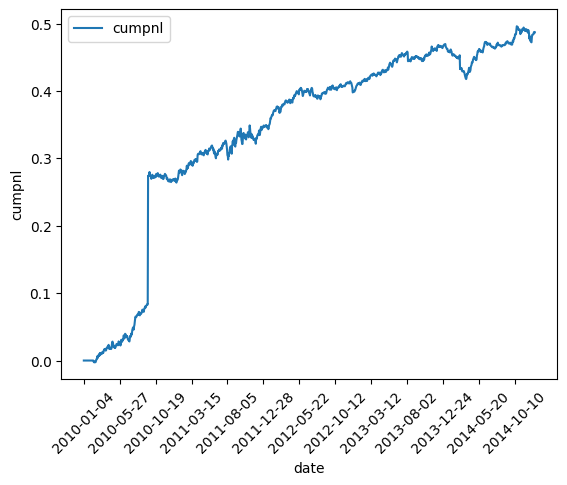

[0.2695260109520612, 0.3473140554702917, 0.39939789977267454, 0.46926656155942514, 0.48750808161577136]


In [72]:
AlphaStats(alpha_28, close_df)

In [73]:
%%time 
alpha = prep_alpha(high, low, close, volume, adv_window, corr_window)

CPU times: user 1.04 s, sys: 27.6 ms, total: 1.07 s
Wall time: 1.07 s


из сигнала:
    из ADV: (n - adv_w) * adv_w * m, где n - кол-во дней, adv_w - величина окна, m - кол-во инструментов
    + n * (c_w * 4m (из корреляции))



из сигнала: O((n - adv_w) * adv_w * m + n * (c_w * 4m)) ≈ O(n * m*(adv_w + 4 * c_w))

из замедления: O((n - d_w) * (3 * d_w * m + m)) ≈ O(n * m * 3 * d_w)

из вырезания выбросов: O(n * (m*m + 2 * cut_out_w)) ≈ O(n * m^2)

из вырезания средниx: O(n * (m*m + 2 * cut_mid_w)) ≈ O(n * m^2)

из объединения нулей: O(n*m)

из нейтрализации с выбросом: O(n * (5* m + 2 * zeros_num)) ≈ O(5 * m * n)

из нормализации: O(2 * n * m)

Итого: O(n * m* (adv_w + 4 * c_w) + n * m * 3 * d_w + 2 * n * m^2 + 8 * n*m) ≈ O(n*m(adv_w + 4 * c_w + 3 * d_w + 2* m + 8)) ≈ O(2*n*m^2)

# Треугольник

In [77]:
def is_triangle(sides: 'list[int]') -> str:
    max = 0
    for item in sides:
        if item == 0:
            return 'NO'
        if item > max:
            max = item
    if a + b + c - max > max:
        return 'YES'
    return 'NO'

# Уравнение в целых числах

In [85]:
# √ax+ b = c

def solve_equation(a, b, c):
    if c < 0:
        return None
    elif a == 0:
        if c**2 == b:
            return 'Any'
        else:
            return None
    else:
        if (c**2 - b) % a == 0:
            return (c**2 - b) // a
        else:
            return None

In [88]:
print(solve_equation(1, 0, 0))
print(solve_equation(1, 2, 3))
print(solve_equation(0, 1, 1))
print(solve_equation(-1, 0, 1))
print(solve_equation(1, 2, -3))

0
7
Any
-1
None


In [217]:
no_solution = 'NO SOLUTION'
many_sol = 'MANY SOLUTIONS'

def solve_equation(a, b, c):
    if c < 0:
        return no_solution
    elif a == 0:
        if c**2 == b:
            return many_sol
        else:
            return no_solution
    else:
        if (c**2 - b) % a == 0:
            return (c**2 - b) // a
        else:
            return no_solution


if __name__ == "__main__":
    a = int(input())
    b = int(input())
    c = int(input())

    print(solve_equation(a, b, c))

 1
 0
 0


0


# Номер подъезда

Бригада скорой помощи выехала по вызову в один из отделенных районов. К сожалению, когда диспетчер получил вызов, он успел записать только адрес дома и номер квартиры K1, а затем связь прервалась. Однако он вспомнил, что по этому же адресу дома некоторое время назад скорая помощь выезжала в квартиру K2, которая расположена в подъезда P2 на этаже N2. Известно, что в доме M этажей и количество квартир на каждой лестничной площадке одинаково. Напишите программу, которая вычилсяет номер подъезда P1 и номер этажа N1 квартиры K1.

**Формат ввода**

Во входном файле записаны пять положительных целых чисел K1, M, K2, P2, N2. Все числа не превосходят 10^6.

**Формат вывода**

Выведите два числа P1 и N1. Если входные данные не позволяют однозначно определить P1 или N1, вместо соответствующего числа напечатайте 0. Если входные данные противоречивы, напечатайте два числа –1 (минус один).

*Пример 1*

Ввод: 89 20 41 1 11 Вывод: 2 3

*Пример 2*

Ввод: 11 1 1 1 1 Вывод: 0 1

*Пример 3*

Ввод: 3 2 2 2 1 Вывод: -1 -1

In [91]:
import math

In [159]:
def entrance_number(k1, M, k2, p2, n2):
    if k1 == k2:
        return p2, n2
    if M <= k2 and p2 > 1:
        return -1, -1
    if k1 < k2 and p2 == 1:
        p1 = 1
        if math.ceil(k2/((p2-1)*M + n2)) * ((p2-1)*M + n2) > k2 and (math.ceil(k2/((p2-1)*M + n2))+1) * ((p2-1)*M + n2) > k2:
            return p1, 0
        n1 = (k1 - (p1 - 1)*M*g) // g + (k1 - (p1 - 1)*M*g) % g
        return p1, n1
        
    if M == 1:
        n1 = 1
        if p2 == 1 and n1 == 1:
            return 0, n1
        else:
            g = math.ceil(k2/((p2-1)*M + n2))
            p1 = math.ceil(k1 / (M * g))
            return p1, n1
    g = math.ceil(k2/((p2-1)*M + n2))
    p1 = math.ceil(k1 / (M * g))
    n1 = (k1 - (p1 - 1)*M*g) // g + (k1 - (p1 - 1)*M*g) % g
    return p1, n1

In [160]:
print(entrance_number(89, 20, 41, 1, 11))
print(entrance_number(11, 1, 1, 1, 1))
print(entrance_number(3, 2, 2, 2, 1))
print(entrance_number(4, 2, 5, 1, 2))  # 1 0

(2, 3)
(0, 1)
(-1, -1)
(1, 0)


In [219]:
import math

def entrance_number():
    nums = input().split(',')
    k1 = int(nums[0])
    M = int(nums[1])
    k2 = int(nums[2])
    p2 = int(nums[3])
    n2 = int(nums[4])
    if k1 == k2:
        return p2, n2
    if M <= k2 and p2 > 1:
        return -1, -1
    if k1 < k2 and p2 == 1:
        p1 = 1
        if math.ceil(k2/((p2-1)*M + n2)) * ((p2-1)*M + n2) > k2 and (math.ceil(k2/((p2-1)*M + n2))+1) * ((p2-1)*M + n2) > k2:
            return p1, 0
        n1 = (k1 - (p1 - 1)*M*g) // g + (k1 - (p1 - 1)*M*g) % g
        return p1, n1
        
    if M == 1:
        n1 = 1
        if p2 == 1 and n1 == 1:
            return 0, n1
        else:
            g = math.ceil(k2/((p2-1)*M + n2))
            p1 = math.ceil(k1 / (M * g))
            return p1, n1
    g = math.ceil(k2/((p2-1)*M + n2))
    p1 = math.ceil(k1 / (M * g))
    n1 = (k1 - (p1 - 1)*M*g) // g + (k1 - (p1 - 1)*M*g) % g
    return p1, n1
    
    
if __name__ == "__main__":
    print(entrance_number())

 89, 20, 41, 1, 11


(2, 3)


# Сплавы

Имеется N кг металлического сплава. Из него изготавливают заготовки массой K кг каждая. После этого из каждой заготовки вытачиваются детали массой M кг каждая (из каждой заготовки вытачивают максимально возможное количество деталей). Если от заготовок после этого что-то остается, то этот материал возвращают к началу производственного цикла и сплавляют с тем, что осталось при изготовлении заготовок. Если того сплава, который получился, достаточно для изготовления хотя бы одной заготовки, то из него снова изготавливают заготовки, из них – детали и т.д. Напишите программу, которая вычислит, какое количество деталей может быть получено по этой технологии из имеющихся исходно N кг сплава.

**Формат ввода**

Вводятся N, K, M. Все числа натуральные и не превосходят 200.

**Формат вывода**

Выведите одно число — количество деталей, которое может получиться по такой технологии.

*Пример 1*

Ввод: 10 5 2 Вывод: 4

*Пример 2*

Ввод: 13 5 3 Вывод: 3

*Пример 3*

Ввод: 14 5 3 Вывод: 4

In [214]:
def tools(n, k, m):
    product = 0
    remains = n
    if n < k or k < m or n < m:
        return 0
    while remains >= k:
        k_nums = remains // k
        remains -= k * k_nums
        product += k_nums * (k // m)
        remains += k_nums * (k % m)
    return product

In [215]:
print(tools(10, 5, 2))
print(tools(13, 5, 3))
print(tools(14, 5, 3))

4
3
4


In [216]:
def tools(n, k, m):
    product = 0
    remains = n
    if n < k or k < m or n < m:
        return 0
    while remains >= k:
        k_nums = remains // k
        remains -= k * k_nums
        product += k_nums * (k // m)
        remains += k_nums * (k % m)
    return product
    
 
if __name__ == "__main__":
    nums = input()
    figs = nums.split()
    print(tools(int(figs[0]), int(figs[1]), int(figs[2])))

 10 5 2


4


In [192]:
import math

def table(a, b, c, d):
    square = a * b + c * d
    # length = sum(sorted([a, b, c, d])[2:])
    length = max([max([a, b]) + min([c, d]), min([a, b]) + max([c, d])])
    width = square // length
    while square > width * length:
        width += 1
    return width, length

In [193]:
print(table(10, 2, 2, 10))
print(table(5,7,3,2))

(4, 12)
(5, 9)


# Узник замка Иф

За многие годы заточения узник замка Иф проделал в стене прямоугольное отверстие размером D × E. Замок Иф сложен из кирпичей, размером A × B × C. Определите, сможет ли узник выбрасывать кирпичи в море через это отверстие, если стороны кирпича должны быть параллельны сторонам отверстия.

**Формат ввода**

Программа получает на вход числа A, B, C, D, E.

**Формат вывода**

Программа должна вывести слово YES или NO.

*Пример 1*

Ввод: 1 1 1 1 1 (построчно)

Вывод: YES

*Пример 2*

Ввод: 2 2 2 1 1 (построчно) 

Вывод: NO

In [224]:
yes = "YES"
no = "NO"

def fit_hole(a, b, c, d, e):
    if d * e >= a * b and min([d, e]) >= min([a, b]) and max([d, e]) >= max([a, b]):
        return yes
    if d * e >= c * b and min([d, e]) >= min([c, b]) and max([d, e]) >= max([c, b]):
        return yes
    if d * e >= a * c and min([d, e]) >= min([a, c]) and max([d, e]) >= max([a, c]):
        return yes
    return no

In [225]:
print(fit_hole(1, 1, 1, 1, 1))
print(fit_hole(2, 2, 2, 1, 1))

YES
NO


In [226]:
yes = "YES"
no = "NO"

def fit_hole(a, b, c, d, e):
    if d * e >= a * b and min([d, e]) >= min([a, b]) and max([d, e]) >= max([a, b]):
        return yes
    if d * e >= c * b and min([d, e]) >= min([c, b]) and max([d, e]) >= max([c, b]):
        return yes
    if d * e >= a * c and min([d, e]) >= min([a, c]) and max([d, e]) >= max([a, c]):
        return yes
    return no
    
    
if __name__ == "__main__":
    a = int(input())
    b = int(input())
    c = int(input())
    d = int(input())
    e = int(input())
    
    print(fit_hole(a, b, c, d, e))

 1
 1
 1
 1
 1


YES


# Система линейных уравнений

Даны числа a,b,c,d,e,f. Решить систему линейных уравнений:

ax+by=e

cx+dy=f

Учесть все возможные случаи.

1. Если система не имеет решений, то программа должна вывести единственное число 0.
2. Если система имеет бесконечно много решений, каждое из которых имеет вид y=kx+b, то программа должна вывести число 1, а затем значения k и b.
3. Если система имеет единственное решение (x0,y0), то программа должна вывести число 2, а затем значения x0 и y0.
4. Если система имеет бесконечно много решений вида x=x0, y — любое, то программа должна вывести число 3, а затем значение x0.
5. Если система имеет бесконечно много решений вида y=y0, x — любое, то программа должна вывести число 4, а затем значение y0.
6. Если любая пара чисел (x,y) является решением, то программа должна вывести число 5.

In [273]:
def solve_system(a, b, c, d, e, f):
    if a == 0 and b == 0 and c == 0 and d == 0:
        if e == 0 and f == 0:
            print(5)
        else:
            print(0)
    elif a == 0 and b == 0:
        if e != 0:
            print(0)
        elif c == 0 and d != 0:
            print(4, f / d)
        elif d == 0 and c != 0:
            print(3, f / c)
        elif c != 0 and d != 0:
            print(1, - c / d, f / d)
        else:
            print(0)
    elif c == 0 and d == 0:
        if f != 0:
            print(0)
        elif a == 0 and b != 0:
            print(4, e / b)
        elif a!= 0 and b == 0:
            print(3, e / a)
        elif a != 0 and b != 0:
            print(1, -a / b, e / b)
        else:
            print(0)
    elif a == 0 and c == 0:
        if e / b == f / d:
            print(4, e / b)
        else: 
            print(0)
    elif b == 0 and d == 0:
        if e / a == f / c:
            print(3, e / a)
        else:
            print(0)
    elif (a!=0 and  b!= 0 and c !=0 and d != 0) and (a / c == b / d):
        if e == 0 and f == 0:
            print(1, -a / b, 0)
        elif e == 0 and f != 0:
            print(0)
        elif e != 0 and f == 0:
            print(0)
        elif a / c == e / f:
            print(1, -a / b, e / b)
        else:
            print(0)
    elif a*d - b*c == 0:
        if (e*d-b*f) == 0 and (e*c - a*f) == 0:
            print(5)
        else:
            print(0)
    else:
        print(2, (e*d - b*f) / (a*d - c*b), (a*f - e*c) / (a*d - b*c))

In [274]:
solve_system(1, 0, 0, 1, 3, 3)  # 2, 3, 3
solve_system(1, 1, 2, 2, 1, 2)  # 1 -1 1
solve_system(0, 2, 0, 4, 1, 2)  # 4 0.5

2 3.0 3.0
1 -1.0 1.0
4 0.5


In [275]:
def solve_system(a, b, c, d, e, f):
    if a == 0 and b == 0 and c == 0 and d == 0:
        if e == 0 and f == 0:
            print(5)
        else:
            print(0)
    elif a == 0 and b == 0:
        if e != 0:
            print(0)
        elif c == 0 and d != 0:
            print(4, f / d)
        elif d == 0 and c != 0:
            print(3, f / c)
        elif c != 0 and d != 0:
            print(1, - c / d, f / d)
        else:
            print(0)
    elif c == 0 and d == 0:
        if f != 0:
            print(0)
        elif a == 0 and b != 0:
            print(4, e / b)
        elif a!= 0 and b == 0:
            print(3, e / a)
        elif a != 0 and b != 0:
            print(1, -a / b, e / b)
        else:
            print(0)
    elif a == 0 and c == 0:
        if e / b == f / d:
            print(4, e / b)
        else: 
            print(0)
    elif b == 0 and d == 0:
        if e / a == f / c:
            print(3, e / a)
        else:
            print(0)
    #elif (a!=0 and  b!= 0 and c !=0 and d != 0) and (a % c == 0 or c % a == 0) and ( b % d == 0 or d % b == 0):
    elif (a!=0 and  b!= 0 and c !=0 and d != 0) and (a / c == b / d):
        if e == 0 and f == 0:
            print(1, -a / b, 0)
        elif e == 0 and f != 0:
            print(0)
        elif e != 0 and f == 0:
            print(0)
        elif a / c == e / f:
            print(1, -a / b, e / b)
        else:
            print(0)
    elif a*d - b*c == 0:
        if (e*d-b*f) == 0 and (e*c - a*f) == 0:
            print(5)
        else:
            print(0)
    else:
        print(2, (e*d - b*f) / (a*d - c*b), (a*f - e*c) / (a*d - b*c))
        
        
if __name__ == "__main__":
    a = float(input())
    b = float(input())
    c = float(input())
    d = float(input())
    e = float(input())
    f = float(input())
    
    solve_system(a, b, c, d, e, f)

 1
 1
 1
 1
 1
 1


1 -1.0 1.0
